# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

/Users/adamyang/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/adamyang/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [2]:
categories = ['alt.atheism', 'talk.religion.misc', 'comp.graphics', 'sci.space']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
# Note to grader: I had to change the code here so that num_test/2 is an integer rather than a float.
test_data, test_labels = newsgroups_test.data[int(num_test/2):], newsgroups_test.target[int(num_test/2):]
dev_data, dev_labels = newsgroups_test.data[:int(num_test/2)], newsgroups_test.target[:int(num_test/2)]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print ('training label shape:', train_labels.shape)
print ('test label shape:', test_labels.shape)
print ('dev label shape:', dev_labels.shape)
print ('labels names:', newsgroups_train.target_names)

training label shape: (2034,)
test label shape: (677,)
dev label shape: (676,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


## Question 1

(1) For each of the first 5 training examples, print the text of the message along with the label.

[2 pts]

In [3]:
### STUDENT START ###

# Class created to simply bold or add color to printed text.
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

def P1(num_examples=5):
    """
    Input the number of examples you want to print. Output the text for each example,
    along with the label number as well as the label name.
    """
    for i in range(num_examples):
        # Print text of example
        print("{}Text number {} is:{}\n{}\n".format(color.BOLD,i+1,color.END,train_data[i]))
        # Print label number and label name for the text 
        print("{}{}The label for this text is {} and the label name is {}{}\n"
              .format(color.RED,color.BOLD,train_labels[i],
                      newsgroups_train.target_names[train_labels[i]],color.END))
    
### STUDENT END ###
P1()

Text number 1 is:
Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych

The label for this text is 1 and the label name is comp.graphics

Text number 2 is:


Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes like Koresh have been demonstr

## Question 2

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

[6 pts]

**Assumptions:**
- I am assuming that we do not carry over the changes from one part to the next. For example, part (e) would not include the ngram character features we implemented in part (d).
- I am assuming that in part (d) we are only including the bigram and trigram features and excluding the unigram features. Therefore, I created cases for ngram_range = (2,2), (3,3) and (2,3).

In [4]:
# Note to grader: I am assuming that we do not carry over the changes from one part to the next
# For example, part (e) would not include the ngram character features we implemented in part (d)

def P2():
### STUDENT START ###
    Vectorizer = CountVectorizer()
    fitted = Vectorizer.fit_transform(train_data)
    # Each row of fitted is a message and each column is a unique word.
    # Numbers in the matrix are counts of each word per message.
    
    print("part (a):")
    # What is the size of the vocabulary?
    a1 = len(Vectorizer.get_feature_names())
    print("The size of the vocabulary is {} unique words".format(a1))
    # What is the average number of non-zero features per example?
    a2 = np.mean(fitted.getnnz(1))
    print("The average number of non-zero features per example is {:.2f}".format(a2))
    # What fraction of the entries in the matrix are non-zero?
    a3 = fitted.nnz/(fitted.shape[0]*fitted.shape[1])
    print("The fraction of the entries in the matrix that are non-zero is {:6f}".format(a3))
    
    print("part (b):")
    # What are the 0th and last feature strings (in alphabetical order)?
    b1 = [Vectorizer.get_feature_names()[0], Vectorizer.get_feature_names()[a1-1]]
    print("The 0th feature string is \"{:s}\" and the last feature string is \"{:s}\"".format(b1[0], b1[1]))
    
    print("part (c):")
    # Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]
    vocab = ["atheism", "graphics", "space", "religion"]
    Vectorizer = CountVectorizer(vocabulary = vocab)
    fitted = Vectorizer.fit_transform(train_data)
    # Confirm the training vectors are appropriately shaped
    print("The training vectors have the shape of: {}".format(fitted.shape))
    # What's the average number of non-zero features per example?
    c1 = np.mean(fitted.getnnz(1))
    print("The average number of non-zero features per example is now {:.2f}".format(c1))
    
    print("part (d):")
    # Use "analyzer" and "ngram_range" to extract bigram and trigram character features
    Vectorizer = CountVectorizer(analyzer="char", ngram_range=(2,2))
    fitted = Vectorizer.fit_transform(train_data)
    # What size vocabulary does this yield?
    d1 = len(Vectorizer.get_feature_names())
    print("The size of the vocabulary consisting of only the bigram "
          "character features is {} unique features".format(d1))
    
    Vectorizer = CountVectorizer(analyzer="char", ngram_range=(3,3))
    fitted = Vectorizer.fit_transform(train_data)
    # What size vocabulary does this yield?
    d1 = len(Vectorizer.get_feature_names())
    print("The size of the vocabulary consisting of only the trigram "
          "character features is {} unique features".format(d1))
    
    Vectorizer = CountVectorizer(analyzer="char", ngram_range=(2,3))
    fitted = Vectorizer.fit_transform(train_data)
    # What size vocabulary does this yield?
    d1 = len(Vectorizer.get_feature_names())
    print("The size of the vocabulary consisting of both the bigram "
          "and trigram character features is {} unique features".format(d1))
    
    print("part (e):")
    # Use the "min_df" argument to prune words that appear in fewer than 10 documents
    Vectorizer = CountVectorizer(min_df = 10)
    fitted = Vectorizer.fit_transform(train_data)
    # What size vocabulary does this yield?
    e1 = len(Vectorizer.get_feature_names())
    print("The size of the vocabulary after pruning uncommon words is {} unique words".format(e1))
    
    print("part (f):")
    # Build the standard CountVectorizer for both train and dev data
    Vectorizer_T = CountVectorizer()
    Vectorizer_D = CountVectorizer()
    fitted_T = Vectorizer_T.fit_transform(train_data)
    fitted_D = Vectorizer_D.fit_transform(dev_data)
    # What fraction of the words in the dev data are missing from the vocabulary?
    TrainWords = Vectorizer_T.get_feature_names()
    DevWords = Vectorizer_D.get_feature_names()
    count = 0
    for word in DevWords:
        if word in TrainWords:
            pass
        else:
            count += 1
    print("The fraction of words in the dev data that are missing from "
          "the train data vocabulary is {:4f}".format(count/len(DevWords)))
    
### STUDENT END ###
P2()

part (a):
The size of the vocabulary is 26879 unique words
The average number of non-zero features per example is 96.71
The fraction of the entries in the matrix that are non-zero is 0.003598
part (b):
The 0th feature string is "00" and the last feature string is "zyxel"
part (c):
The training vectors have the shape of: (2034, 4)
The average number of non-zero features per example is now 0.27
part (d):
The size of the vocabulary consisting of only the bigram character features is 3291 unique features
The size of the vocabulary consisting of only the trigram character features is 32187 unique features
The size of the vocabulary consisting of both the bigram and trigram character features is 35478 unique features
part (e):
The size of the vocabulary after pruning uncommon words is 3064 unique words
part (f):
The fraction of words in the dev data that are missing from the train data vocabulary is 0.247876


## Question 3

(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

[4 pts]

**Assumptions:**
- I used micro averages when calculating the f1score because there are quite a bit fewer data labeled as religion compared to space.
- I wasn't sure if I should use GridSearchCV or iteration to find the optimal k, alpha, and C values for each of the models. On one hand, GridSearchCV does not give the true highest f1score when testing the dev data while interation does. On the other hand, GridSearchCV does multiple cross validations on the training data while iteration does not. In the case of iteration, the k, alpha, and C values might be overfitted to the dev data and less generalized compared to the GridSearchCV. I wrestled with which to use and decided to provide both.
- To figure out the optimal k value for the k-NN model, I decided to try a range of integers between 1 to 200. If i only tried a range of integers between 1 and 100, I would get an optimal k of 96.

**Adam Yang: First I wanted to take a look at the distribution of each label under train and dev data to determine if I should use micro or macro averages for f1 score.**

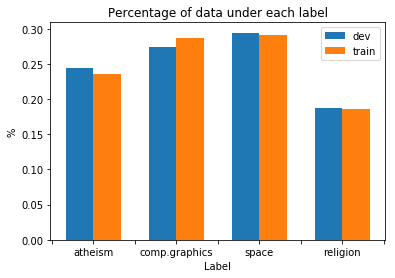

In [5]:
### STUDENT START ###
# This segment of code will is used to help me figure out if I should use micro or macro averages for f1 score

len_dev = len(dev_labels)
len_train = len(train_labels)
dev_dist = [len(dev_labels[dev_labels == 0])/len_dev, len(dev_labels[dev_labels == 1])/len_dev,
           len(dev_labels[dev_labels == 2])/len_dev, len(dev_labels[dev_labels == 3])/len_dev]
train_dist = [len(train_labels[train_labels == 0])/len_train, len(train_labels[train_labels == 1])/len_train,
           len(train_labels[train_labels == 2])/len_train, len(train_labels[train_labels == 3])/len_train]
indices = range(4)
width = np.min(np.diff(indices))/3.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.bar(indices-width/2., dev_dist, width = width)
ax.bar(indices+width/2., train_dist, width = width)
ax.axes.set_xticklabels(["","","atheism","","comp.graphics","","space","","religion"])
ax.legend(["dev", "train"])
plt.title("Percentage of data under each label")
plt.xlabel("Label")
plt.ylabel("%")
plt.show()
### STUDENT END ###

**Adam Yang: As shown above, there are fewer labels categorized under religion for both dev and train data so I decided to use micro averaging in the f1 score.**

**In the code below, I wrote 2 methods to find the optimal k value and the highest f1score. One method was to use GridSearchCV and the second method is to iteratively calculate the f1score for each of the k values. I decided to use the iterative approach because it actually utilzes the dev data to figure out the optimal k value while the GridSearchCV method breaks up the training data into pieces to find the optimal k value. I was hoping that results will end up being the same but unfortunately that was not the case.**

For kNN:
Using GridSearchCV
The optimal k value obtained from GridSearchCV is 151
Using GridSearchCV, this results in an f1score of 0.4503
The micro f1score with this k value on the dev data is 0.4423
Using Iteration


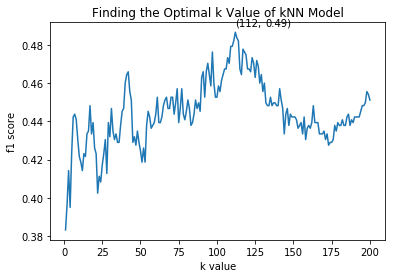

The best k value between 1 and 200 obtained through iteration is 112
This results in the best f1score of 0.4867


In [6]:
### STUDENT START ###
### k Nearest Neighbor ###

# Build a default CountVectorizer
# Fit the CountVectorizer to the training data
# Transform the dev data to fit in the CountVectorizer
Vectorizer = CountVectorizer()
vectorized_T = Vectorizer.fit_transform(train_data)
vectorized_D = Vectorizer.transform(dev_data)

def kNNf1score(train_data, train_labels, dev_data, dev_labels, k):
    """Function that inputs train and dev data and k value and 
    ouputs an f1 score for kNN model"""
    kNN = KNeighborsClassifier(n_neighbors=k)
    kNN.fit(train_data, train_labels)
    dev_predict = kNN.predict(dev_data)
    return(metrics.f1_score(dev_labels, dev_predict, average="micro"))

def P3():
    print("{}For kNN:{}".format(color.BOLD, color.END))
    ### Using GridSearchCV to find the best k value ###
    print("{}Using GridSearchCV{}".format(color.RED, color.END))
    n_neighbors = {"n_neighbors":[i for i in range(1,201)]} 
    Grid = GridSearchCV(KNeighborsClassifier(), n_neighbors)
    Grid.fit(vectorized_T, train_labels)
    print("The optimal k value obtained from GridSearchCV is {}".format(Grid.best_params_["n_neighbors"]))
    print("Using GridSearchCV, this results in an f1score of {:.4f}".format(Grid.best_score_))
    print("The micro f1score with this k value on the dev data is {:.4f}"
          .format(kNNf1score(vectorized_T,train_labels,vectorized_D,
                             dev_labels,Grid.best_params_["n_neighbors"])))
    

    ### Using iteration to find the best k value ###
    print("{}Using Iteration{}".format(color.RED, color.END))
    k = range(1,201)
    f1scores = []
    best_k = 0
    best_f1score = 0
    for i in k:
        # Calculate the f1score using dev data for each k value
        f1score = kNNf1score(vectorized_T,train_labels,vectorized_D,dev_labels,i)
        # Add f1score to list for plotting
        f1scores.append(f1score)
        if f1score > best_f1score:
            # Figure out what the best k value and f1score are.
            best_k = i
            best_f1score = f1score
    plt.plot(k,f1scores)
    plt.annotate('%s)' %0.49, xy=(112,0.49), xytext=(30,0), textcoords='offset points')
    plt.annotate('(%s,' %112, xy=(112,0.49))
    plt.title("Finding the Optimal k Value of kNN Model")
    plt.xlabel("k value")
    plt.ylabel("f1 score")
    plt.show()
    print("The best k value between 1 and 200 obtained through iteration is {}".format(best_k))
    print("This results in the best f1score of {:.4f}".format(best_f1score))

### STUDENT END ###
P3()

For Multinomial Naive Bayes:
Using GridSearchCV
The best alpha value obtained using GridSearchCV is 0.02
Using GridSearchCV, this results in an f1score of 0.8289
The micro f1score with this alpha value on the dev data is 0.7870
Using Iteration


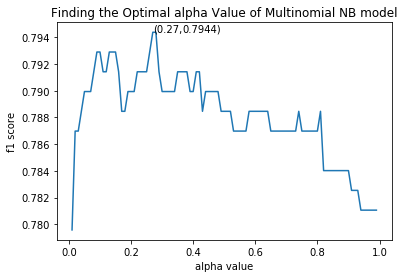

The best alpha value is 0.27
This results in the best f1score of 0.7944


In [7]:
### STUDENT START ###
### Multinomial Naive Bayes ###

def NBf1score(train_data, train_labels, dev_data, dev_labels, alpha):
    """Function that inputs train and dev data and alpha value and 
    ouputs an f1 score for Multinomial Naive Bayes model"""
    NB = MultinomialNB(alpha=alpha)
    NB.fit(train_data, train_labels)
    dev_predict = NB.predict(dev_data)
    return(metrics.f1_score(dev_labels, dev_predict, average="micro"))

def P3():
    print("{}For Multinomial Naive Bayes:{}".format(color.BOLD, color.END))
    ### Using GridSearchCV to find the best alpha value ###
    print("{}Using GridSearchCV{}".format(color.RED, color.END))
    alphas = {'alpha': [i/100 for i in range(1,100)]} 
    Grid = GridSearchCV(MultinomialNB(), alphas)
    Grid.fit(vectorized_T, train_labels)
    print("The best alpha value obtained using GridSearchCV is {}".format(Grid.best_params_["alpha"]))
    print("Using GridSearchCV, this results in an f1score of {:.4f}".format(Grid.best_score_))
    print("The micro f1score with this alpha value on the dev data is {:.4f}"
          .format(NBf1score(vectorized_T,train_labels,
                            vectorized_D,dev_labels,Grid.best_params_["alpha"])))

    ### Using iteration to find the best alpha value ###
    print("{}Using Iteration{}".format(color.RED, color.END))
    alphas = [i/100 for i in range(1,100)]
    f1scores = []
    best_alpha = 0
    best_f1score = 0
    for i in alphas:
        # Calculate the f1score using dev data for each alpha value
        f1score = NBf1score(vectorized_T,train_labels,vectorized_D,dev_labels,i)
        # Add f1score to list for plotting
        f1scores.append(f1score)
        if f1score > best_f1score:
            # Figure out what the best k value and f1score are.
            best_alpha = i
            best_f1score = f1score
    plt.plot(alphas,f1scores)
    plt.title("Finding the Optimal alpha Value of Multinomial NB model")
    plt.xlabel("alpha value")
    plt.ylabel("f1 score")
    plt.annotate('%s)' %0.7944, xy=(0.27,0.7944), xytext=(30,0), textcoords='offset points')
    plt.annotate('(%s,' %0.27, xy=(0.27,0.7944))
    plt.show()
    print("The best alpha value is {}".format(best_alpha))
    print("This results in the best f1score of {:.4f}".format(best_f1score))
P3()
### STUDENT END ###

For Logistic Regression:
Using GridSearchCV
The best C value obtained using GridSearchCV is 0.2
Using GridSearchCV, this results in an f1score of 0.7763
The micro f1score with this C value on the dev data is 0.7130
Using Iteration


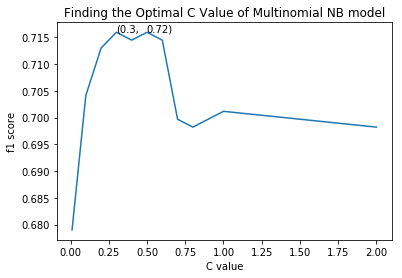

The best C value is 0.3
This results in the best f1score of 0.7160


In [8]:
### STUDENT START ###
### Logistic Regression ###

# fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization.

def Logisticf1score(train_data, train_labels, dev_data, dev_labels, C):
    """Function that inputs train and dev data and C value and 
    ouputs an f1 score for Logistic Regression model"""
    LR = LogisticRegression(C=C)
    LR.fit(train_data, train_labels)
    dev_predict = LR.predict(dev_data)
    return(metrics.f1_score(dev_labels, dev_predict, average="micro"))

def P3():
    print("{}For Logistic Regression:{}".format(color.BOLD, color.END))
    ### Using GridSearchCV to find the best C value ###
    print("{}Using GridSearchCV{}".format(color.RED, color.END))
    C = {'C': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0]} 
    Grid = GridSearchCV(LogisticRegression(), C)
    Grid.fit(vectorized_T, train_labels)
    print("The best C value obtained using GridSearchCV is {}".format(Grid.best_params_["C"]))
    print("Using GridSearchCV, this results in an f1score of {:.4f}".format(Grid.best_score_))
    print("The micro f1score with this C value on the dev data is {:.4f}"
          .format(Logisticf1score(vectorized_T,train_labels,
                            vectorized_D,dev_labels,Grid.best_params_["C"])))

    ### Using iteration to find the best alpha value ###
    print("{}Using Iteration{}".format(color.RED, color.END))
    C = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0]
    f1scores = []
    best_C = 0
    best_f1score = 0
    for i in C:
        # Calculate the f1score using dev data for each C value
        f1score = Logisticf1score(vectorized_T,train_labels,vectorized_D,dev_labels,i)
        # Add f1score to list for plotting
        f1scores.append(f1score)
        if f1score > best_f1score:
            # Figure out what the best k value and f1score are.
            best_C = i
            best_f1score = f1score
    plt.plot(C,f1scores)
    plt.title("Finding the Optimal C Value of Multinomial NB model")
    plt.xlabel("C value")
    plt.ylabel("f1 score")
    plt.annotate('%s)' %0.72, xy=(0.3,0.7160), xytext=(30,0), textcoords='offset points')
    plt.annotate('(%s,' %0.3, xy=(0.3,0.7160))
    plt.show()
    print("The best C value is {}".format(best_C))
    print("This results in the best f1score of {:.4f}".format(best_f1score))
    
P3()
### STUDENT END ###

*Why doesn't nearest neighbors work well for this problem?*

**ANSWER:** In a k nearest neighbors model, the closest neighboring points to the point we are trying to classify are used to determine the point of that classification. The k nearest neighbors model suffers from the curse of dimensionality where if there is a large multidimensional feature space, the training set will give a poor sampling of the feature space and all the points in the feature would be spread very far apart. Subsequently, it will be very hard for the model to figure out how to properly classify a given point in that feature space. In this case, we have 26,879 features which is much too big of a feature space for a k-NN model to perform well. On top of this, our data is very sparse as we have many zeros in our count-vectorized matrix, which would also contribute to the poor performance of the k-NN model.

*Any ideas why logistic regression doesn't work as well as Naive Bayes?*

**ANSWER:** Logistic regression and Naive Bayes are both linear classifiers that assign weights to each word to help classify a string of words into a certain category. The main difference is how they assign the weights to each word. Naive Bayes estimates the joint probability p(x,y) from the training data and applies Bayes rule to predict p(y|x) which is used to determine how likely a message is of a certain label given the words that it includes. Logistic regression on the other hand, estimates p(y|x) directly from the training data by minimizing the error of the fit. On top of this, Naive Bayes has the assumption that each of the features (words) are conditionally independent. However, most words are not truly conditionally independent so Naive Bayes will have higher bias than logistic regression. But because Naive Bayes is assuming conditional independence and is essentially using multiple univariate estimators, it would have smaller variance than than logistic regression which is a multivariate estimator. Because of the smaller variance (and bias possibly working in our favor), I believe that Naive Bayes would work better with the sample size we have. We only have 2034 training instances, which means there might not be enough data for a logistic regression to estimate p(y|x) directly with accuracy without overfitting. If the size of the training data was increased, I would expect to see the logistic regression overtake Naive Bayes.

**Actual Answer:** Logistic regression doesn't work as well beacuse the number of training examples is small in comparison with the number of features (2034 training examples vs. 26879 features). This is related to the probabilities estimated by each model; logistic regression estimates the conditional probabilities P(y|x) directly while naive bayes estimates the joint probability P(y,x). The few training examples and high number of features make it relatively easier to estimate the latter than the former.

*Logistic regression estimates a weight vector for each class, which you can access with the coef_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.*

**ANSWER:** The sum of squared weight values are shown below. It looks like when the C value increases, the sum of squared roots also increases. This makes sense because the smaller the C value, the stronger the regularization strength. Regularization penalizes the magnitude of your parameters when there are a lot of them in order to reduce overfitting when you have many parameters. Therefore, it makes sense that when we decrease the C value, we are increasing the regularization strength, which causes the magnitude of all of the coefficients to be decreased.

In [9]:
### STUDENT START ###
### Answer to part C ###
def Logisticf1score(train_data, train_labels, C):
    """Function that inputs train and C value and 
    ouputs the coefficients for Logistic Regression model"""
    LR = LogisticRegression(C=C)
    LR.fit(train_data, train_labels)
    return(LR.coef_)

def P3():
    C = [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0]
    for i in C:
        print("For C = {}".format(i))
        # Calculate the coef_attribute for each C value
        coefs = Logisticf1score(vectorized_T,train_labels,i)
        sumsquared = np.sum(np.square(coefs), axis=1)
        print("Sum of squared weight values: {}".format(np.round(sumsquared, 2)))        
P3()

### STUDENT END ###

For C = 0.01
Sum of squared weight values: [2.54 2.94 2.86 2.25]
For C = 0.1
Sum of squared weight values: [27.13 24.66 27.46 23.02]
For C = 0.2
Sum of squared weight values: [49.74 42.74 49.33 42.67]
For C = 0.3
Sum of squared weight values: [69.29 57.88 67.9  59.75]
For C = 0.4
Sum of squared weight values: [86.74 71.17 84.25 75.06]
For C = 0.5
Sum of squared weight values: [102.59  83.12  99.03  88.99]
For C = 0.6
Sum of squared weight values: [117.24  94.04 112.52 101.86]
For C = 0.7
Sum of squared weight values: [130.89 104.17 124.95 113.9 ]
For C = 0.8
Sum of squared weight values: [143.56 113.62 136.68 125.06]
For C = 0.9
Sum of squared weight values: [155.67 122.51 147.62 135.57]
For C = 1.0
Sum of squared weight values: [167.   130.92 158.02 145.72]
For C = 2.0
Sum of squared weight values: [257.67 197.98 239.94 226.67]


## Question 4

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

[5 pts]

***Assumptions:***
- I am assuming that for the bigram CountVectorizer, we only include the bigram words. Therefore, ngram_range = (2,2).
- I set a C value for the logistic regression as 0.2 because earlier we found this to provide a more accurate model.
- I am assuming we are looking for the largest positive weights instead of the largest absolute weights because the positive weights indicate which words are mostly likely included for each label.
- I am assuming for the bigram vectorizer, we use the "word" analyzer instead of "char" because it makes much more sense to use combinations of words than combination of characters.

In [10]:
### STUDENT START ###

# Build a default CountVectorizer
# Fit the CountVectorizer to the training data
# Unigram
Vectorizer = CountVectorizer()
vectorized_T = Vectorizer.fit_transform(train_data)
# Bigram
Vectorizer2 = CountVectorizer(ngram_range=(2,2))
vectorized_T2 = Vectorizer2.fit_transform(train_data)

def P4():
    # Train a unigram logistic regression model
    # I used C = 0.2 because we found that to be a possible ideal C value for this data
    LR = LogisticRegression(C = 0.2)
    LR.fit(vectorized_T, train_labels)
    
    # Find the 5 features with the largest weights for each label
    # I am assuming we are looking for the largest positive weights because 
    # they indicate which words are most likely part of each label.
    indices = np.argsort(LR.coef_, axis = 1)[:,::-1][:,0:5]
    coefs = np.sort(LR.coef_, axis = 1)[:,::-1][:,0:5]
    
    # Print out the 5 parameters for each label
    print("{}{}For the Unigram Example:{}".format(color.UNDERLINE,color.BOLD,color.END))
    for i in range(4):
        print("{}Under the {} label:{}".format(color.BOLD,newsgroups_train.target_names[i],color.END))
        for j in range(5):
            print("The word \"{}\", with index {}, and a coefficient of {:.4f}"
                  .format(Vectorizer.get_feature_names()[indices[i,j]],indices[i,j], coefs[i,j]))
            
    # Create a table that shows the weight for each of these features for each of the labels
    print("\n{}Table for Unigram Logistic Regression{}".format(color.BOLD,color.END))
    print("{:^20}|{:^20}|{:^20}|{:^20}|{:^20}|".format("Feature",newsgroups_train.target_names[0],
                                             newsgroups_train.target_names[1],
                                             newsgroups_train.target_names[2],
                                             newsgroups_train.target_names[3]))
    for index in indices.flatten():
        print("{:20}|{:20}|{:20}|{:20}|{:20}|".format(Vectorizer.get_feature_names()[index],
                                                        np.round(LR.coef_[0,index],4),
                                                        np.round(LR.coef_[1,index],4),
                                                        np.round(LR.coef_[2,index],4),
                                                        np.round(LR.coef_[3,index],4)))
    
    # Train a bigram logistic regression model
    LR2 = LogisticRegression(C = 0.2)
    LR2.fit(vectorized_T2, train_labels)
    
    # Find the 5 features with the largest weights for each label
    indices2 = np.argsort(LR2.coef_, axis = 1)[:,::-1][:,0:5]
    coefs2 = np.sort(LR2.coef_, axis = 1)[:,::-1][:,0:5]
    
    # Print out the 5 parameters for each label
    print("\n{}{}For the Bigram Example:{}".format(color.UNDERLINE,color.BOLD,color.END))
    for i in range(4):
        print("{}Under the {} label:{}".format(color.BOLD,newsgroups_train.target_names[i],color.END))
        for j in range(5):
            print("The word \"{}\", with index {}, and a coefficient of {:.4f}"
                  .format(Vectorizer2.get_feature_names()[indices2[i,j]],indices2[i,j], coefs2[i,j]))
    
    # Create a table that shows the weight for each of these features for each of the labels
    print("\n{}Table for Bigram Logistic Regression{}".format(color.BOLD,color.END))
    print("{:^20}|{:^20}|{:^20}|{:^20}|{:^20}|".format("Feature",newsgroups_train.target_names[0],
                                             newsgroups_train.target_names[1],
                                             newsgroups_train.target_names[2],
                                             newsgroups_train.target_names[3]))
    for index in indices2.flatten():
        print("{:20}|{:20}|{:20}|{:20}|{:20}|".format(Vectorizer2.get_feature_names()[index],
                                                        np.round(LR2.coef_[0,index],4),
                                                        np.round(LR2.coef_[1,index],4),
                                                        np.round(LR2.coef_[2,index],4),
                                                        np.round(LR2.coef_[3,index],4)))
P4()

### STUDENT END ###

For the Unigram Example:
Under the alt.atheism label:
The word "bobby", with index 4784, and a coefficient of 0.6193
The word "atheism", with index 3866, and a coefficient of 0.6158
The word "religion", with index 20430, and a coefficient of 0.6153
The word "atheists", with index 3870, and a coefficient of 0.6065
The word "islam", with index 13668, and a coefficient of 0.5281
Under the comp.graphics label:
The word "graphics", with index 11552, and a coefficient of 1.2552
The word "image", with index 12769, and a coefficient of 0.8328
The word "file", with index 10376, and a coefficient of 0.8082
The word "3d", with index 1145, and a coefficient of 0.7104
The word "computer", with index 6555, and a coefficient of 0.6793
Under the sci.space label:
The word "space", with index 22567, and a coefficient of 1.5060
The word "orbit", with index 17597, and a coefficient of 0.7623
The word "nasa", with index 16697, and a coefficient of 0.6645
The word "launch", with index 14540, and a coefficie

*Any surprising features in this table (The bigram table)?*

**ANSWER:** I think I am surprised that features like "in this", "is not", "are you", "it was", etc made the list because they are so general and can apply to any type of sentence. I think the unigram logistic regression is a better model overall and even if we wanted to include bigram features in our model, we should keep the unigram features in the model. One interesting bigram feature is "cheers kent" which appears to be the highest weighted feature for both atheism and religion. I think maybe this guy Kent writes a lot about atheism and religion and ends his writings with "cheers kent", which is why it is such a strong feature for those two categories.

## Question 5

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

[4 pts]

***Assumptions:***
- Assuming that we are expected to use the default logistic regression classifier where C = 1 and L2 regularization.
- I used the "weighted" average f1score because the "micro" average f1score that I have been using is the same as the accuracy score.
- I created a "best_preprocessor" which I played around with for a long time to try and get the highest accuracy. It is very much overfitted to the specific training and dev data because I only included things that helped increase the accuracy. This was just for fun to see how high I can get the accuracy.

In [11]:
### STUDENT START ###
def empty_preprocessor(s):
    return s

def better_preprocessor(s):
    # Remove symbols
    s = re.sub(r"[_@$&%#]","",s)
    
    # Remove certain suffixes
    s = re.sub(r"y\b|s\b|ed\b|ly\b|ing\b","",s)
    
    # Remove the stop words
    s = " ".join([word for word in s.split() if word not in ENGLISH_STOP_WORDS])
    
    return s

def best_preprocessor(s):
    # This preprocessor is very much overfitting to our specific train and dev data.
    # The only purpose of this is to see how high I can get the accuracy.
    
    # Remove "_" and "@" symbols
    s = re.sub(r"[_@]","",s)
    
    # Remove certain suffixes
    s = re.sub(r"y\b|s\b|ed\b|ly\b","",s)
    
    # Remove certain English Stop Words
    s = re.sub(r" your | had | do | between | before ","",s)
    
    return s

def P5():
    
    for preprocessor in [empty_preprocessor, better_preprocessor, best_preprocessor]:
        print("{}For {}:{}".format(color.BOLD,preprocessor.__name__,color.END))
        # First preprocess each message in the train_data and dev data
        preproc_train = [preprocessor(message) for message in train_data]
        preproc_dev = [preprocessor(message) for message in dev_data]

        # Create a CountVectorizer for the preprocessed training data and dev data
        Vectorizer = CountVectorizer()
        vectorized_T = Vectorizer.fit_transform(preproc_train)
        vectorized_D = Vectorizer.transform(preproc_dev)
        print("The size of the dictionary is {}".format(len(Vectorizer.get_feature_names())))
        #print(Vectorizer.get_feature_names())
        
        # Build a logistic regression classifier
        LR = LogisticRegression()
        LR.fit(vectorized_T, train_labels)
        
        # Print out the accuracy and f1score
        print("The accuracy is {:.5f}".format(LR.score(vectorized_D,dev_labels)))
        dev_predict = LR.predict(vectorized_D)
        print("The \"weighted\" average f1score is {:.5f}"
              .format(metrics.f1_score(dev_labels, dev_predict, average="weighted")))
P5()
### STUDENT END ###

For empty_preprocessor:
The size of the dictionary is 26879
The accuracy is 0.70118
The "weighted" average f1score is 0.69609
For better_preprocessor:
The size of the dictionary is 22454
The accuracy is 0.72633
The "weighted" average f1score is 0.72057
For best_preprocessor:
The size of the dictionary is 24750
The accuracy is 0.73669
The "weighted" average f1score is 0.73285


With your new preprocessor, how much did you reduce the size of the dictionary?

**ANSWER:** I reduced the size of the dictionary by 4425 with my "better_preprocessor". The accuracy was increased by around 2.5 points for the "better_preprocessor".

## Question 6

(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

[4 pts]

The number of learned weights that are not equal to zero using L1 Regularization is 1609
The accuracy is 0.6879
The number of learned weights that are not equal to zero using L2 Regularization is 107516
The accuracy is 0.7012
The number of learned weights that are not equal to zero using L2 Regularization on the reduced vocabulary is 3832
The accuracy is 0.6805


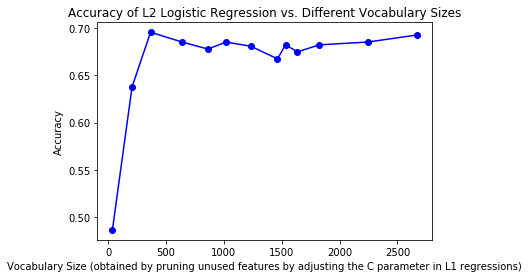

In [12]:
### STUDENT START ###

def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)
    
    Vectorizer = CountVectorizer()
    vectorized_T = Vectorizer.fit_transform(train_data)
    vectorized_D = Vectorizer.transform(dev_data)
    # Build a Logistic Regression Model using L1 regularization
    LR = LogisticRegression(penalty="l1")
    LR.fit(vectorized_T, train_labels)
    # Output the number of learned weights that are not equal to zero
    num_coefs = np.count_nonzero(LR.coef_)
    print("The number of learned weights that are not equal to "
          "zero using L1 Regularization is {}".format(num_coefs))
    accuracy = LR.score(vectorized_D, dev_labels)
    print("The accuracy is {:.4f}".format(accuracy))
    
    # Build a Logistic Regression Model using L2 regularization
    LR2 = LogisticRegression(penalty="l2")
    LR2.fit(vectorized_T, train_labels)
    # Output the number of learned weights that are not equal to zero
    num_coefs2 = np.count_nonzero(LR2.coef_)
    print("The number of learned weights that are not equal to "
          "zero using L2 Regularization is {}".format(num_coefs2))
    accuracy2 = LR2.score(vectorized_D, dev_labels)
    print("The accuracy is {:.4f}".format(accuracy2))

    # Now, reduce the size of the vocabulary by keeping only those features 
    # that have at least one non-zero weight and retrain a modeling using "l2".
    # These are the unique indices of all the non-zero weight words.
    # I looked for unique indices because each index can appear up to 4 times.
    indices = np.unique(np.nonzero(LR.coef_)[1])
    wordlist = np.array(Vectorizer.get_feature_names())[indices]
    Vectorizer = CountVectorizer(vocabulary=wordlist)
    vectorized_T = Vectorizer.fit_transform(train_data)
    vectorized_D = Vectorizer.transform(dev_data)
    LR3 = LogisticRegression(penalty="l2")
    LR3.fit(vectorized_T, train_labels)
    num_coefs3 = np.count_nonzero(LR3.coef_)
    print("The number of learned weights that are not equal to "
          "zero using L2 Regularization on the reduced vocabulary is {}".format(num_coefs3))
    accuracy3 = LR3.score(vectorized_D, dev_labels)
    print("The accuracy is {:.4f}".format(accuracy3))
    
    # Make a plot showing accuracy of the re-trained model vs. the vocabulary size you 
    # get when pruning unused features by adjusting the C parameter.
    C = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 2.0]
    vocab_sizes = []
    accuracies = []
    for c in C:
        # Find a smaller vocab size with "l1" regularization
        Vectorizer = CountVectorizer()
        vectorized_T = Vectorizer.fit_transform(train_data)
        LR = LogisticRegression(penalty="l1", C = c, tol=0.01)
        LR.fit(vectorized_T, train_labels)
        # Add vocab size to the list
        vocab_sizes.append(np.count_nonzero(LR.coef_))
        indices = np.unique(np.nonzero(LR.coef_)[1])
        wordlist = np.array(Vectorizer.get_feature_names())[indices]
        # Create a new vectorizer and "l2" logistic regression with new vocab list
        Vectorizer = CountVectorizer(vocabulary=wordlist)
        vectorized_T = Vectorizer.fit_transform(train_data)
        vectorized_D = Vectorizer.transform(dev_data)
        # I am assuming we keep C = 1 for this regression
        LR2 = LogisticRegression(penalty="l2", tol=0.01)
        LR2.fit(vectorized_T, train_labels)
        accuracies.append(LR2.score(vectorized_D, dev_labels))
    plt.plot(vocab_sizes, accuracies, "bo-")
    plt.title("Accuracy of L2 Logistic Regression vs. Different Vocabulary Sizes")
    plt.xlabel("Vocabulary Size (obtained by pruning unused features by adjusting the C parameter in L1 regressions)")
    plt.ylabel("Accuracy")
P6()
### STUDENT END ###

*How does the number of non-zero weights you get with "l1" compare to the number of non-zero weights you get with "l2"?*

**ANSWER:** Using L1 regularization, we get 1609 non-zero weights which is 105907 fewer than if we used L2 regularization. 

## Question 7

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

[4 pts]

In [13]:
### STUDENT START ###
def P7():
    # Create a TfidfVectorizer
    Vectorizer = TfidfVectorizer()
    vectorized_T = Vectorizer.fit_transform(train_data)
    vectorized_D = Vectorizer.transform(dev_data)
    # Create a Logistic Regression with C = 100
    LR = LogisticRegression(C = 100)
    LR.fit(vectorized_T, train_labels)
    # Find the predict probabilities in for each label for each message 
    probs = LR.predict_proba(vectorized_D)
    # Iterate through these probabilities to find the R ratio
    Rratio = []
    for i in range(len(probs)):
        # Find the maximum predicted probability for this message
        maxpredprob = np.max(probs[i])
        # Find the correct label for this message
        corr_label = dev_labels[i]
        # Find the predicted probability associated of the correct label for this message
        corrpredprob = probs[i][corr_label]
        # Find the R ratio
        R = maxpredprob/corrpredprob
        Rratio.append(R)
    # Find the top 3 R ratios and their indices
    TopRs = np.sort(Rratio)[::-1][:3]
    TopRsIndex = np.argsort(Rratio)[::-1][:3]
    labels = newsgroups_train.target_names
    
    for i in range(3):
        order = ["1st","2nd","3rd"]
        print("{}The {} highest R value is {:.4f}{}".format(color.BOLD,order[i],TopRs[i],color.END))
        predprobs = probs[TopRsIndex[i]]
        print("The predicted probabilities are {}".format(predprobs))
        print("This means the predicted label for this message is {}".format(labels[np.argmax(predprobs)]))
        print("The actual label for this message is {}".format(labels[dev_labels[TopRsIndex[i]]]))
        print("The message is:\n\n{}\n".format(dev_data[TopRsIndex[i]]))
    
    indices = np.argsort(LR.coef_, axis = 1)[:,::-1][:,0:5]
    coefs = np.sort(LR.coef_, axis = 1)[:,::-1][:,0:5]
    
    # Print out the 5 parameters for each label
    print("{}{}The highest weighted words for each label:{}".format(color.UNDERLINE,color.BOLD,color.END))
    for i in range(4):
        print("{}Under the {} label:{}".format(color.BOLD,labels[i],color.END))
        for j in range(5):
            print("The word \"{}\", with index {}, and a coefficient of {:.4f}"
                  .format(Vectorizer.get_feature_names()[indices[i,j]],indices[i,j], coefs[i,j]))
            
    # Print accuracy
    print("\n{}The accuracy of this model is {}{}"
          .format(color.BOLD,LR.score(vectorized_D, dev_labels),color.END))
P7()
### STUDENT END ###

The 1st highest R value is 929.3574
The predicted probabilities are [0.00196657 0.99371933 0.00324484 0.00106925]
This means the predicted label for this message is comp.graphics
The actual label for this message is talk.religion.misc
The message is:

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the


*How is the TfidfVectorizer different from the CountVectorizer?*

**ANSWER:** The CountVectorizer simply counts how many times that word appears in each message. TfidfVectorizer on the other hand outputs a value that is proportional to the count of that word in the message, but also penalizes that value if the word is used in multiple messages. Therefore, it adds a layer of penalyzing commonly used words. 

*What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.*

**ANSWER:** The first and second pieces of text are both about religion but are incorrectly labeled as computer graphics. This is probably due to the fact that the first text goes into detail of how to acquire the Book of Mormon text online and uses a lot of technical computer related words like "ftp", "RTF", "ASCII", "LaTex", etc. The first piece of text also includes the word "file" twice which is the 4th heavist weighted word for predicting the computer graphics label. Other than the word "Mormon" there aren't a lot of uniquely religious words included in that piece of text. The second text is similar where it includes words like "ftp", "site", "online", "email", "internet" which can fall under the computer graphics label but only the word "Mormon" which falls under the religion label. Because the two pieces of text include so how many technical computer terms and few religious technical terms they are mislabeled. The third piece of text is supposed to fall under the atheism label but is incorrectly labeled as religion. Just looking at the text by itself, even my human brain is unable to determine what category it should fall under. If you look at the most heavily weighted words for religion, it includes words like "blood", "fbi", "order" which are rather violent and militaristic. Maybe a lot of the texts used in the training set that fall under religion are very violent and militaristic in nature. Therefore I can understand why the third piece of text is mislabeled as religion.

The first thing I would do is probably decrease the C value. Right now it is set to 100 which is really high and giving each of the words too much weight. I might decrease it to 1 or 0.2 as I have before. Another thing I may try is to include bigram features as well. Maybe with this, freatures like "Book of" and "of Mormon" might help label the religious texts.

## Question 8 - Extra Credit

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

- [1 pt] for a reasonable attempt
- [2 pts] for improved performance

In [371]:
### STUDENT START ###
def P8():
    # Create a TfidfVectorizer
    Vectorizer = TfidfVectorizer()
    vectorized_T = Vectorizer.fit_transform(train_data)
    vectorized_D = Vectorizer.transform(dev_data)
    # Create a Logistic Regression with C = 1
    LR = LogisticRegression(C = 1)
    LR.fit(vectorized_T, train_labels)
    # Find the predict probabilities in for each label for each message 
    probs = LR.predict_proba(vectorized_D)
    # Iterate through these probabilities to find the R ratio
    Rratio = []
    for i in range(len(probs)):
        # Find the maximum predicted probability for this message
        maxpredprob = np.max(probs[i])
        # Find the correct label for this message
        corr_label = dev_labels[i]
        # Find the predicted probability associated of the correct label for this message
        corrpredprob = probs[i][corr_label]
        # Find the R ratio
        R = maxpredprob/corrpredprob
        Rratio.append(R)
    # Find the top 3 R ratios and their indices
    TopRs = np.sort(Rratio)[::-1][:3]
    TopRsIndex = np.argsort(Rratio)[::-1][:3]
    labels = newsgroups_train.target_names
    
    for i in range(3):
        order = ["1st","2nd","3rd"]
        print("{}The {} highest R value is {:.4f}{}".format(color.BOLD,order[i],TopRs[i],color.END))
        predprobs = probs[TopRsIndex[i]]
        print("The predicted probabilities are {}".format(predprobs))
        print("This means the predicted label for this message is {}".format(labels[np.argmax(predprobs)]))
        print("The actual label for this message is {}".format(labels[dev_labels[TopRsIndex[i]]]))
        print("The message is:\n\n{}\n".format(dev_data[TopRsIndex[i]]))
    
    indices = np.argsort(LR.coef_, axis = 1)[:,::-1][:,0:5]
    coefs = np.sort(LR.coef_, axis = 1)[:,::-1][:,0:5]
    
    # Print out the 5 parameters for each label
    print("{}{}The highest weighted words for each label:{}".format(color.UNDERLINE,color.BOLD,color.END))
    for i in range(4):
        print("{}Under the {} label:{}".format(color.BOLD,labels[i],color.END))
        for j in range(5):
            print("The word \"{}\", with index {}, and a coefficient of {:.4f}"
                  .format(Vectorizer.get_feature_names()[indices[i,j]],indices[i,j], coefs[i,j]))
            
    # Print accuracy
    print("\n{}The accuracy of this model is {}{}"
          .format(color.BOLD,LR.score(vectorized_D, dev_labels),color.END))
P8()
### STUDENT END ###

The 1st highest R value is 8.2901
The predicted probabilities are [0.076177   0.68225717 0.15926777 0.08229807]
This means the predicted label for this message is comp.graphics
The actual label for this message is talk.religion.misc
The message is:

Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.

The 2nd highest R value is 5.0280
The predicted probabilities are [0.11449491 0.61250742 0.15117837 0.12181929]
This means the predicted label for this message is comp.graphics
The actual label for this message is talk.religion.misc
The message is:

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many

**ANSWER:** When you decrease the C value to 1, the accuracy drops to 0.7204 (0.0429 decrease) which is not great. The R ratios are also decreased a lot which is an improvement.

In [372]:
### STUDENT START ###
def P8():
    # Create a TfidfVectorizer with unigram and bigram features
    Vectorizer = TfidfVectorizer(ngram_range=(1,2))
    vectorized_T = Vectorizer.fit_transform(train_data)
    vectorized_D = Vectorizer.transform(dev_data)
    # Create a Logistic Regression with C = 100
    LR = LogisticRegression(C = 100)
    LR.fit(vectorized_T, train_labels)
    # Find the predict probabilities in for each label for each message 
    probs = LR.predict_proba(vectorized_D)
    # Iterate through these probabilities to find the R ratio
    Rratio = []
    for i in range(len(probs)):
        # Find the maximum predicted probability for this message
        maxpredprob = np.max(probs[i])
        # Find the correct label for this message
        corr_label = dev_labels[i]
        # Find the predicted probability associated of the correct label for this message
        corrpredprob = probs[i][corr_label]
        # Find the R ratio
        R = maxpredprob/corrpredprob
        Rratio.append(R)
    # Find the top 3 R ratios and their indices
    TopRs = np.sort(Rratio)[::-1][:3]
    TopRsIndex = np.argsort(Rratio)[::-1][:3]
    labels = newsgroups_train.target_names
    
    for i in range(3):
        order = ["1st","2nd","3rd"]
        print("{}The {} highest R value is {:.4f}{}".format(color.BOLD,order[i],TopRs[i],color.END))
        predprobs = probs[TopRsIndex[i]]
        print("The predicted probabilities are {}".format(predprobs))
        print("This means the predicted label for this message is {}".format(labels[np.argmax(predprobs)]))
        print("The actual label for this message is {}".format(labels[dev_labels[TopRsIndex[i]]]))
        print("The message is:\n\n{}\n".format(dev_data[TopRsIndex[i]]))
    
    indices = np.argsort(LR.coef_, axis = 1)[:,::-1][:,0:5]
    coefs = np.sort(LR.coef_, axis = 1)[:,::-1][:,0:5]
    
    # Print out the 5 parameters for each label
    print("{}{}The highest weighted words for each label:{}".format(color.UNDERLINE,color.BOLD,color.END))
    for i in range(4):
        print("{}Under the {} label:{}".format(color.BOLD,labels[i],color.END))
        for j in range(5):
            print("The word \"{}\", with index {}, and a coefficient of {:.4f}"
                  .format(Vectorizer.get_feature_names()[indices[i,j]],indices[i,j], coefs[i,j]))
            
    # Print accuracy
    print("\n{}The accuracy of this model is {}{}"
          .format(color.BOLD,LR.score(vectorized_D, dev_labels),color.END))
P8()
### STUDENT END ###

The 1st highest R value is 693.9734
The predicted probabilities are [0.00416965 0.98963835 0.00476595 0.00142605]
This means the predicted label for this message is comp.graphics
The actual label for this message is talk.religion.misc
The message is:

I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the


**ANSWER:** When you include bigram features in the model, the accuracy actually improved to 0.7678 (0.0045 improvement). Furthermore, the R ratios are also smaller which is also an improvement.